In [ ]:
pip install windrose

In [ ]:
pip install python-ternary

In [ ]:
!pip install tensorflow keras scikeras

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from matplotlib.dates import DateFormatter
from windrose import WindroseAxes
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import ternary
from scipy.stats import gaussian_kde
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/London2_21_23.csv'

df_pm = pd.read_csv(file_path)

df_pm = df_pm.drop(columns=['v10', 'v2.5', 'nv10', 'nv2.5', 'source', 'co',	'nox', 'no2',	'no',	'o3',	'so2', 'pm10'])


In [ ]:
df_pm['date'] = pd.to_datetime(df_pm['date']).dt.tz_localize(None)
df_pm.head()

,site,code,date,pm2.5,ws,wd,air_temp
0,London N. Kensington,KC1,2021-01-01 00:00:00,30.448,1.5,314.9,-2.1
1,London N. Kensington,KC1,2021-01-01 01:00:00,55.802,2.1,318.7,-2.9
2,London N. Kensington,KC1,2021-01-01 02:00:00,28.278,1.9,310.8,-3.6
3,London N. Kensington,KC1,2021-01-01 03:00:00,15.613,2.0,309.3,-4.0
4,London N. Kensington,KC1,2021-01-01 04:00:00,19.764,2.0,300.4,-4.5


# Missing Values

In [ ]:
missing_values = df_pm.isnull().sum()
missing_values

,0
site,0
code,0
date,0
pm2.5,3256
ws,1008
wd,1008
air_temp,1008


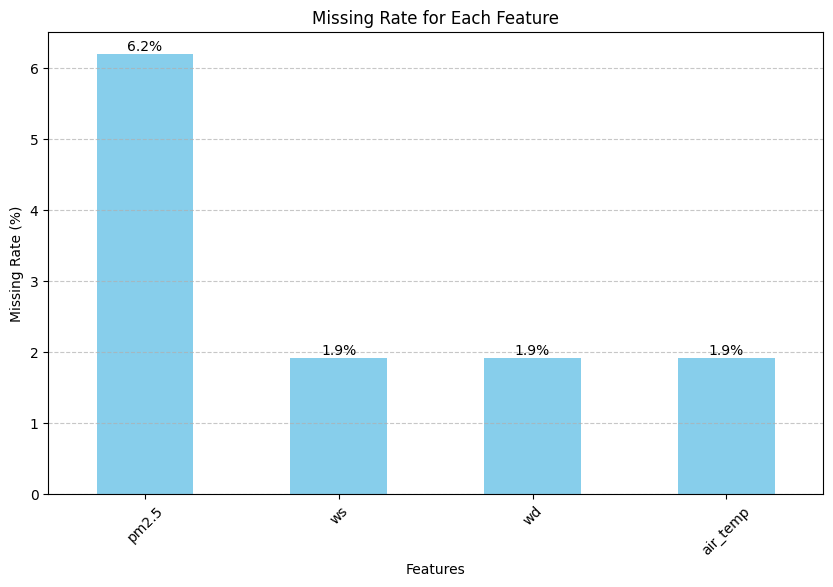

In [ ]:
total_rows = df_pm.shape[0]
missing_rate = missing_values / total_rows * 100

missing_rate = missing_rate.drop(['site', 'code', 'date'])
missing_rate = missing_rate.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = missing_rate.plot(kind='bar', color='skyblue')
plt.title('Missing Rate for Each Feature')
plt.xlabel('Features')
plt.ylabel('Missing Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with the missing rate percentage
for bar in bars.patches:
    height = bar.get_height()
    if height > 0:
        plt.annotate(f'{height:.1f}%',
                     (bar.get_x() + bar.get_width() / 2, height),
                     ha='center', va='bottom')

plt.show()

## Data less than and equal to 0 in the pollutant concentration characteristics are replaced with the smallest positive number.

In [ ]:
# Function to replace non-positive values in 'pm2.5' column
def replace_non_positive(df):
    # Get the minimum positive value in the 'pm2.5' column
    min_positive = df[df['pm2.5'] > 0]['pm2.5'].min()
    # Replace values less than or equal to 0 with the minimum positive value
    df['pm2.5'] = df['pm2.5'].apply(lambda x: min_positive if x <= 0 else x)

# Apply the function to df_pm_nomissing
replace_non_positive(df_pm)

## gap <= 8 Linear Imputation

In [ ]:
df_pm_gap = df_pm.copy()

variables = ['pm2.5', 'ws', 'wd', 'air_temp']
pollutant_columns = ['pm2.5']  # Only these columns need to be > 0

# Function to perform linear interpolation for gaps <= 8 and ensure values > min positive value for pollutant columns
def linear_interpolation(df, variable, max_gap):
    df[variable] = df[variable].interpolate(method='linear', limit=max_gap)
    if variable in pollutant_columns:
        min_positive = df[df[variable] > 0][variable].min()  # Get the minimum positive value in the column
        df[variable] = df[variable].apply(lambda x: min_positive if x <= 0 else x)
    return df

# Perform linear interpolation for gaps <= 8 for each variable
for variable in variables:
    df_pm_gap = linear_interpolation(df_pm_gap, variable, 8)

In [ ]:
missing_values = df_pm_gap.isnull().sum()
missing_values

site           0
code           0
date           0
pm2.5       2857
ws           784
wd           784
air_temp     784
dtype: int64

## gap>8
## meterological data：multiple regression imputation
## pm2.5：Prohet

In [ ]:
# Variables to be imputed
features = ['ws', 'wd', 'air_temp']

# Initialize iterative imputer
imputer = IterativeImputer(random_state=42)

# Create a copy of the original dataframe for imputation
df_pm_nomissing = df_pm_gap.copy()

# Perform imputation on the specified columns
df_pm_nomissing[variables] = imputer.fit_transform(df_pm_nomissing[variables])

## The Prohet time series imputation technique was used for pm2.5, and meteorological data was added into the model as exogenous regression variables to improve the accuracy of inputation

In [ ]:
# Rename the columns as required by Prophet: 'date' to 'ds' and 'pm2.5' to 'y'
df_prophet = df_pm_nomissing[['date', 'pm2.5', 'ws', 'wd', 'air_temp']].rename(columns={'date': 'ds', 'pm2.5': 'y'})

# Initialize the Prophet model
model = Prophet()

# Add external regressors
model.add_regressor('ws')
model.add_regressor('wd')
model.add_regressor('air_temp')

# Fit the model on the data
model.fit(df_prophet)

# Create a dataframe for future predictions
# Here, we create predictions for the same length as the original data
future = model.make_future_dataframe(periods=0, freq='H')

# Add external regressors to the future dataframe
future['ws'] = df_pm_nomissing['ws']
future['wd'] = df_pm_nomissing['wd']
future['air_temp'] = df_pm_nomissing['air_temp']

# Make predictions
forecast = model.predict(future)

# Combine the original data with the forecasted values
# Use 'combine_first' to fill in the missing values in 'y' with 'yhat' from the forecast
df_prophet['y'] = df_prophet['y'].combine_first(forecast['yhat'])

# Rename the columns back to the original names
df_pm2_5 = df_prophet.rename(columns={'ds': 'date', 'y': 'pm2.5'})

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkxvkmx2q/byxqjppn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkxvkmx2q/y48m4c2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27426', 'data', 'file=/tmp/tmpkxvkmx2q/byxqjppn.json', 'init=/tmp/tmpkxvkmx2q/y48m4c2j.json', 'output', 'file=/tmp/tmpkxvkmx2q/prophet_model4wgk96yv/prophet_model-20240729221015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/London2_21_23.csv'

df_pm = pd.read_csv(file_path)

df_pm = df_pm.drop(columns=['v10', 'v2.5', 'nv10', 'nv2.5', 'source', 'co',	'nox', 'no2',	'no',	'o3',	'so2', 'pm10'])

In [ ]:
df_pm2_5['site'] = df_pm['site']
df_pm2_5['code'] = df_pm['code']

In [ ]:
df_pm2_5.head(-10)

,date,pm2.5,ws,wd,air_temp,site,code
0,2021-01-01 00:00:00,30.448,1.5,314.9,-2.1,London N. Kensington,KC1
1,2021-01-01 01:00:00,55.802,2.1,318.7,-2.9,London N. Kensington,KC1
2,2021-01-01 02:00:00,28.278,1.9,310.8,-3.6,London N. Kensington,KC1
3,2021-01-01 03:00:00,15.613,2.0,309.3,-4.0,London N. Kensington,KC1
4,2021-01-01 04:00:00,19.764,2.0,300.4,-4.5,London N. Kensington,KC1
...,...,...,...,...,...,...,...
52545,2023-12-31 09:00:00,4.000,6.0,218.1,8.2,London Marylebone Road,MY1
52546,2023-12-31 10:00:00,6.000,6.4,223.6,8.4,London Marylebone Road,MY1
52547,2023-12-31 11:00:00,6.000,6.2,232.5,9.1,London Marylebone Road,MY1
52548,2023-12-31 12:00:00,4.000,6.1,235.9,9.3,London Marylebone Road,MY1


## --> ensure positive values

In [ ]:
# Function to replace non-positive values in 'pm2.5' column
def replace_non_positive(df):
    # Get the minimum positive value in the 'pm2.5' column
    min_positive = df[df['pm2.5'] > 0]['pm2.5'].min()
    # Replace values less than or equal to 0 with the minimum positive value
    df['pm2.5'] = df['pm2.5'].apply(lambda x: min_positive if x <= 0 else x)

# Apply the function to df_pm_nomissing
replace_non_positive(df_pm2_5)

In [ ]:
missing_values = df_pm2_5.isnull().sum()
missing_values

date        0
pm2.5       0
ws          0
wd          0
air_temp    0
site        0
code        0
dtype: int64

# (Partial) Autocorrelation

<Figure size 1200x600 with 0 Axes>

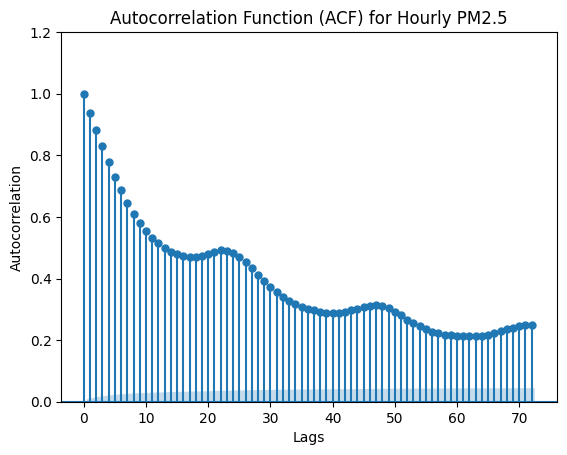

In [ ]:
# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df_pm2_5['pm2.5'], lags=72)
plt.title('Autocorrelation Function (ACF) for Hourly PM2.5')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.ylim(0, 1.2)
plt.show()

In [ ]:
acf_values = acf(df_pm2_5['pm2.5'], nlags=50)

value = []
for i in range(25):
    value.append(acf_values[i])
    print(i, value[i])

0 1.0
1 0.9363776361722939
2 0.8828718713441263
3 0.8301103492137738
4 0.7785165040788975
5 0.7303911154526257
6 0.6863946851667098
7 0.6461142121775301
8 0.6102996134295406
9 0.5789245564313553
10 0.552693002237703
11 0.531762333924329
12 0.5138215729361109
13 0.49925664985856005
14 0.487108782299683
15 0.47819317417884083
16 0.47286141044447005
17 0.47033337172916784
18 0.47116537401106073
19 0.4746644531759801
20 0.4809117576653819
21 0.4864398356522152
22 0.4910339307484029
23 0.48950707242411373
24 0.48391445605245126


<Figure size 1200x600 with 0 Axes>

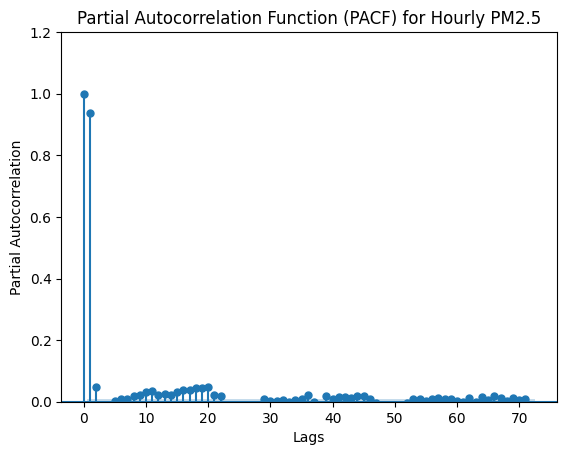

In [ ]:
# Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df_pm2_5['pm2.5'], lags=72)
plt.title('Partial Autocorrelation Function (PACF) for Hourly PM2.5')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.ylim(0, 1.2)
plt.show()

The correlation between KC1 and MY1 is: 0.8381432224069293


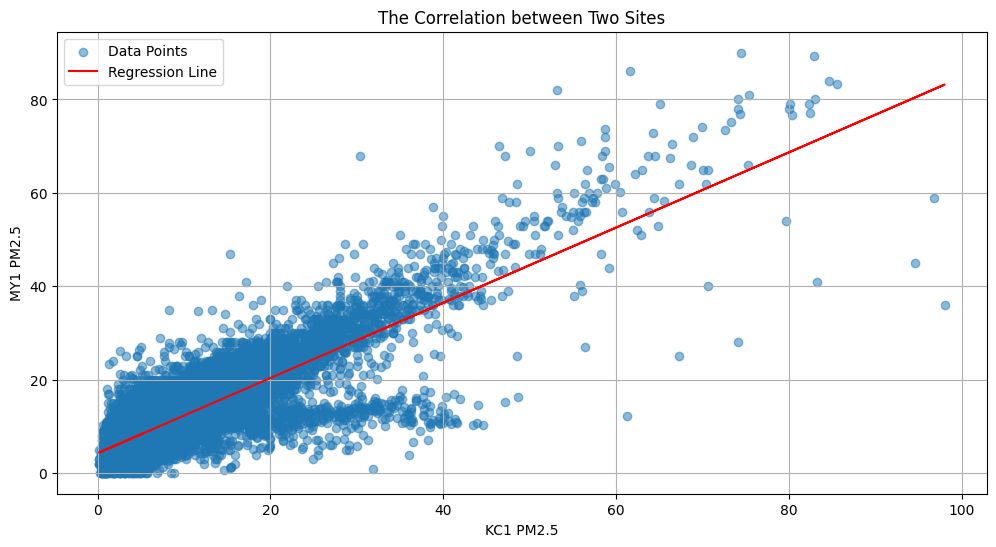

In [ ]:
# Filter data for the two stations
kc1_data = df_pm2_5[df_pm2_5['code'] == 'KC1'].set_index('date')['pm2.5']
my1_data = df_pm2_5[df_pm2_5['code'] == 'MY1'].set_index('date')['pm2.5']

# Ensure the two datasets are aligned by time
kc1_data = kc1_data.sort_index()
my1_data = my1_data.sort_index()

# Calculate the correlation between the two stations
correlation = kc1_data.corr(my1_data)

# Print the correlation
print(f'The correlation between KC1 and MY1 is: {correlation}')

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(kc1_data, my1_data, alpha=0.5, label='Data Points')

# Linear regression line
m, b = np.polyfit(kc1_data, my1_data, 1)
plt.plot(kc1_data, m*kc1_data + b, color='red', label='Regression Line')

plt.title('The Correlation between Two Sites')
plt.xlabel('KC1 PM2.5')
plt.ylabel('MY1 PM2.5')
plt.grid(True)
plt.legend()
plt.show()

# MinMaxScaler

In [ ]:
# Features to minmax scale
features = ['pm2.5', 'ws', 'wd', 'air_temp']

scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df_pm2_5[features] = scaler_minmax.fit_transform(df_pm2_5[features])

# Encoding

In [ ]:
encoder = LabelEncoder()
df_pm2_5['code_encoded'] = encoder.fit_transform(df_pm2_5['code'])
df_pm2_5.head()

,date,pm2.5,ws,wd,air_temp,site,code,code_encoded
0,2021-01-01 00:00:00,0.309930,0.109489,0.874722,0.107612,London N. Kensington,KC1,0
1,2021-01-01 01:00:00,0.568858,0.153285,0.885278,0.086614,London N. Kensington,KC1,0
2,2021-01-01 02:00:00,0.287768,0.138686,0.863333,0.068241,London N. Kensington,KC1,0
3,2021-01-01 03:00:00,0.158427,0.145985,0.859167,0.057743,London N. Kensington,KC1,0
4,2021-01-01 04:00:00,0.200819,0.145985,0.834444,0.044619,London N. Kensington,KC1,0


In [ ]:
from google.colab import files

df_pm2_5.to_csv('df_pm2_5.csv', index=False)

files.download('df_pm2_5.csv')

drive.mount('/content/drive')

df_pm2_5.to_csv('/content/drive/My Drive/df_pm2_5.csv', index=False)

# Modelling

In [ ]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
df_pm2_5 = pd.read_csv('/content/drive/My Drive/df_pm2_5.csv')

# the next hour

In [ ]:
# Create target variable shifted by 1 hour
df_pm2_5['target'] = df_pm2_5['pm2.5'].shift(-1)

# Drop the last row with NaN target due to shifting
df_pm2_5.dropna(inplace=True)

# Select features
features = ['code_encoded', 'pm2.5', 'ws', 'wd', 'air_temp']

# Function to create sequences for LSTM input
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size][features].values)
        y.append(df.iloc[i + window_size]['target'])
    return np.array(X), np.array(y)

# 2h-->1h

In [ ]:
# Set window size to 2 hours to predict the next 1 hours
window_size = 2
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))  # Output layer to predict the next 1 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 2 hours for predicting next 24 hours
RMSE: 0.03337087251572352
MAE: 0.02199939141956533
MAPE: 27.69238550092411%
R²: 0.8019531428603055


# 6h-->1h

In [ ]:
# Set window size to 6 hours to predict the next 1 hours
window_size = 6
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))  # Output layer to predict the next 1 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 6 hours for predicting next 24 hours
RMSE: 0.03472682728153939
MAE: 0.02287791120945182
MAPE: 28.352642058771394%
R²: 0.7805966782090641


# 12h-->1h

In [ ]:
# Set window size to 12 hours to predict the next 1 hours
window_size = 12
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))  # Output layer to predict the next 1 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 12 hours for predicting next 24 hours
RMSE: 0.03228973648465195
MAE: 0.021834354119690483
MAPE: 31.912254611713063%
R²: 0.8102209455209093


# 24h-->1h

In [ ]:
# Set window size to 24 hours to predict the next 1 hours
window_size = 24
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))  # Output layer to predict the next 1 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 24 hours for predicting next 24 hours
RMSE: 0.031213173891853782
MAE: 0.020819881685067196
MAPE: 30.15799980363064%
R²: 0.8243680739249014


## 2 hours

### 64

In [ ]:
# Set window size to 2 hours to predict the next 1 hours
window_size = 2
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=64, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))  # Output layer to predict the next 1 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 2 hours for predicting next 1 hours
RMSE: 0.03286165053386043
MAE: 0.021833923355425593
MAPE: 30.54032278160769%
R²: 0.8079512093157819


## 128

In [ ]:
# Set window size to 2 hours to predict the next 1 hours
window_size = 2
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=128, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))  # Output layer to predict the next 1 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 2 hours for predicting next 1 hours
RMSE: 0.03298610018712318
MAE: 0.021737055381694546
MAPE: 28.85720861991008%
R²: 0.8064938472309192


# The next day

In [ ]:
df_pm2_5 = pd.read_csv('/content/drive/My Drive/df_pm2_5.csv')

In [ ]:
# Create target variable shifted by 24 hours
df_pm2_5['target'] = df_pm2_5['pm2.5'].shift(-24)

# Drop rows with NaN target values due to shifting
df_pm2_5.dropna(inplace=True)

# Select features
features = ['code_encoded', 'pm2.5', 'ws', 'wd', 'air_temp']

# Function to create sequences for LSTM input
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size - 24 + 1):
        X.append(df.iloc[i:i + window_size][features].values)
        y.append(df.iloc[i + window_size:i + window_size + 24]['target'].values)
    return np.array(X), np.array(y)

# 12h-->24h

In [ ]:
# Set window size to 12 hours to predict the next 24 hours
window_size = 12
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 12 hours for predicting next 24 hours
RMSE: 0.061191663186485556
MAE: 0.04201322599817519
MAPE: 71.02866654055367%
R²: 0.32274267642899057


## 36h-->24h

In [ ]:
# Set window size to 36 hours to predict the next 24 hours
window_size = 36
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 36 hours for predicting next 24 hours
RMSE: 0.05086695209465317
MAE: 0.036853126806417225
MAPE: 62.719386291834%
R²: 0.5528697458275644


## 48h-->24h

In [ ]:
# Set window size to 48 hours to predict the next 24 hours
window_size = 48
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 48 hours for predicting next 24 hours
RMSE: 0.04902679399662823
MAE: 0.034819696087314174
MAPE: 54.97733442950074%
R²: 0.5840300606934559


# 48h

## 64unites

In [ ]:
# Set window size to 48 hours to predict the next 24 hours
window_size = 48
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=64, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 48 hours for predicting next 24 hours
RMSE: 0.04105538741789005
MAE: 0.02978139792087094
MAPE: 45.72275912833938%
R²: 0.7083007802949501


## 128

In [ ]:
# Set window size to 48 hours to predict the next 24 hours
window_size = 48
X, y = create_sequences(df_pm2_5, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=128, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 48 hours for predicting next 24 hours
RMSE: 0.034926060485633896
MAE: 0.025845513606032478
MAPE: 40.089832457393356%
R²: 0.7888971183907252
